In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
from __future__ import print_function
import numpy as np
from numpy import linalg as LA
import torch
import numpy as np
import sys, os 

import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import timeit
import time

get_ipython().run_line_magic('matplotlib', 'inline')
import sys, os # tag:RNA # for the import of AccModule
sys.path.append('C:/Users/lenovo/Desktop/opt/') # tag:RNA # import path for AccModule
#import AccelerationModule # tag:RNA # import AccModule

In [38]:
num_workers = 2
batch_size = 100
valid_size = 0.2
# Data augmentation for train data + conversion to tensor
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])
# Data augmentation for test data + conversion to tensor
test_transforms= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
# Picking Fashion-MNIST dataset
train_data = datasets.FashionMNIST('Dataset', train=True, download=True, transform=train_transforms)
test_data = datasets.FashionMNIST('Dataset', train=False, download=True, transform=test_transforms)

In [39]:
# Finding indices for validation set
num_train = len(train_data)
indices = list(range(num_train))

#Randomize indices
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_index, test_index = indices[split:], indices[:split]

# Making samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(test_index)

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Image classes
classes = ['T-shirt/top','Trouser','Pullover','Dress',
           'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [40]:
print('number of samples of training set after data loading: ',len(train_loader))
print('number of samples of valid set after data loading',len(valid_loader))
print('number of samples of test set after data loading',len(test_loader))

number of samples of training set after data loading:  480
number of samples of valid set after data loading 120
number of samples of test set after data loading 100


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = Net()
print(model)
#modelAcc = Net() # tag:RNA # modelAcc is a copy of the network
#print(modelAcc)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [42]:
criterion = nn.CrossEntropyLoss()

In [43]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, dampening = 0, weight_decay = 0)

In [ ]:
##training without RNA
# epochs to train for
epochs = 25
sgd1_train_loss_history=[]
sgd1_train_acc_history=[]
sgd1_valid_loss_history=[]
sgd1_valid_acc_history=[]
sgd1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    sgd1_train_loss = 0
    sgd1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        sgd1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        sgd1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    sgd1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    sgd1_train_loss = sgd1_train_loss/len(train_loader.sampler)
    sgd1_valid_loss = sgd1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    sgd1_epoch_acc = 100 * correct/ total

    sgd1_train_loss_history.append(sgd1_train_loss)
    sgd1_train_acc_history.append(sgd1_epoch_acc)
    
    sgd1_valid_loss_history.append(sgd1_valid_loss)
    sgd1_valid_acc_history.append(sgd1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(sgd1_train_loss, 6)}\nValidation Loss: {round(sgd1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if sgd1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(sgd1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = sgd1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 2.295356
Validation Loss: 2.276734
Validation loss decreased from inf to 2.276734
Saving New Model
Current Epoch: 2
Training Loss: 2.055218
Validation Loss: 1.327169
Validation loss decreased from 2.276734 to 1.327169
Saving New Model
Current Epoch: 3
Training Loss: 1.212476
Validation Loss: 0.90862
Validation loss decreased from 1.327169 to 0.90862
Saving New Model
Current Epoch: 4
Training Loss: 0.904532
Validation Loss: 0.729661
Validation loss decreased from 0.90862 to 0.729661
Saving New Model
Current Epoch: 5
Training Loss: 0.771749
Validation Loss: 0.642573
Validation loss decreased from 0.729661 to 0.642573
Saving New Model
Current Epoch: 6
Training Loss: 0.710025
Validation Loss: 0.604655
Validation loss decreased from 0.642573 to 0.604655
Saving New Model
Current Epoch: 7
Training Loss: 0.669662
Validation Loss: 0.587038
Validation loss decreased from 0.604655 to 0.587038
Saving New Model
Current Epoch: 8
Training Loss: 0.642219
Validation Loss

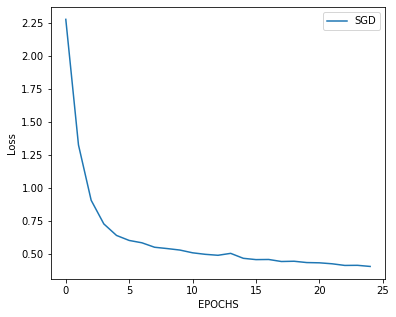

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(sgd1_valid_loss_history, label='SGD')

plt.xlabel('EPOCHS')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

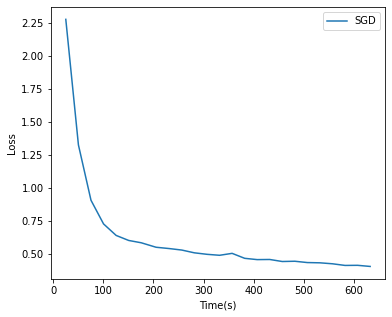

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(sgd1_time,sgd1_valid_loss_history, label='SGD')

plt.xlabel('Time(s)')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

In [ ]:
##Nestrov
##

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)

In [ ]:
##training without RNA
# epochs to train for
epochs = 25
nest1_train_loss_history=[]
nest1_train_acc_history=[]
nest1_valid_loss_history=[]
nest1_valid_acc_history=[]
nest1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    nest1_train_loss = 0
    nest1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        nest1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        nest1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    nest1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    nest1_train_loss = nest1_train_loss/len(train_loader.sampler)
    nest1_valid_loss = nest1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    nest1_epoch_acc = 100 * correct/ total

    nest1_train_loss_history.append(nest1_train_loss)
    nest1_train_acc_history.append(nest1_epoch_acc)
    
    nest1_valid_loss_history.append(nest1_valid_loss)
    nest1_valid_acc_history.append(nest1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(nest1_train_loss, 6)}\nValidation Loss: {round(nest1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if nest1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(nest1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = nest1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 0.448216
Validation Loss: 0.396159
Validation loss decreased from inf to 0.396159
Saving New Model
Current Epoch: 2
Training Loss: 0.4421
Validation Loss: 0.396804
Current Epoch: 3
Training Loss: 0.43963
Validation Loss: 0.395436
Validation loss decreased from 0.396159 to 0.395436
Saving New Model
Current Epoch: 4
Training Loss: 0.433934
Validation Loss: 0.389196
Validation loss decreased from 0.395436 to 0.389196
Saving New Model
Current Epoch: 5
Training Loss: 0.427165
Validation Loss: 0.392069
Current Epoch: 6
Training Loss: 0.41996
Validation Loss: 0.378648
Validation loss decreased from 0.389196 to 0.378648
Saving New Model
Current Epoch: 7
Training Loss: 0.416456
Validation Loss: 0.377107
Validation loss decreased from 0.378648 to 0.377107
Saving New Model
Current Epoch: 8
Training Loss: 0.414385
Validation Loss: 0.368444
Validation loss decreased from 0.377107 to 0.368444
Saving New Model
Current Epoch: 9
Training Loss: 0.409335
Validation Loss: 0

Text(0, 0.5, 'loss')

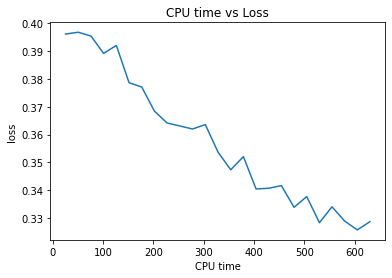

In [ ]:
plt.plot(nest1_time, nest1_valid_loss_history)
plt.title('CPU time vs Loss')
plt.xlabel('CPU time')
plt.ylabel('loss')

In [ ]:
##GD

##GD using RMS prop

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

##nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [ ]:
##training without RNA
# epochs to train for
epochs = 25
gd1_train_loss_history=[]
gd1_train_acc_history=[]
gd1_valid_loss_history=[]
gd1_valid_acc_history=[]
gd1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    gd1_train_loss = 0
    gd1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        gd1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        gd1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    gd1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    gd1_train_loss = gd1_train_loss/len(train_loader.sampler)
    gd1_valid_loss = gd1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    gd1_epoch_acc = 100 * correct/ total

    gd1_train_loss_history.append(gd1_train_loss)
    gd1_train_acc_history.append(gd1_epoch_acc)
    
    gd1_valid_loss_history.append(gd1_valid_loss)
    gd1_valid_acc_history.append(gd1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gd1_train_loss, 6)}\nValidation Loss: {round(gd1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if gd1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(gd1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = gd1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 0.930861
Validation Loss: 0.41533
Validation loss decreased from inf to 0.41533
Saving New Model
Current Epoch: 2
Training Loss: 0.465027
Validation Loss: 0.459265
Current Epoch: 3
Training Loss: 0.426489
Validation Loss: 0.375074
Validation loss decreased from 0.41533 to 0.375074
Saving New Model
Current Epoch: 4
Training Loss: 0.396263
Validation Loss: 0.339792
Validation loss decreased from 0.375074 to 0.339792
Saving New Model
Current Epoch: 5
Training Loss: 0.373725
Validation Loss: 0.3203
Validation loss decreased from 0.339792 to 0.3203
Saving New Model
Current Epoch: 6
Training Loss: 0.356442
Validation Loss: 0.323141
Current Epoch: 7
Training Loss: 0.344511
Validation Loss: 0.305812
Validation loss decreased from 0.3203 to 0.305812
Saving New Model
Current Epoch: 8
Training Loss: 0.332561
Validation Loss: 0.30178
Validation loss decreased from 0.305812 to 0.30178
Saving New Model
Current Epoch: 9
Training Loss: 0.323691
Validation Loss: 0.307149

In [44]:
##GD plus momentum

##GD using RMS prop

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

In [ ]:
##training without RNA
# epochs to train for
epochs = 25
gdm1_train_loss_history=[]
gdm1_train_acc_history=[]
gdm1_valid_loss_history=[]
gdm1_valid_acc_history=[]
gdm1_time = []
start = time.time()
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 

for epoch in range(1, epochs+1):## loop over the data set multiple times
    
    gdm1_train_loss = 0
    gdm1_valid_loss = 0
    
    # training steps
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):##get the inputs 
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target = data.cuda, target.cuda
        # clears gradients
        optimizer.zero_grad() ##gradients set to zero
        # forward pass
        output = model(data) ##foward propagation
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward() ##backward propagation
        # update paremeters
        optimizer.step() ##optimize
        # update training loss
        gdm1_train_loss += loss.item()*data.size(0) ##
        
    # validation steps
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        if torch.cuda.is_available():
            data, target =  data.cuda, target.cuda
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1) 
        # update validation loss
        gdm1_valid_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    gdm1_time.append(elapsed_time_fl)
        
        
        # Total number of labels
    total = target.size(0)

        # Total correct predictions
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    #correct = torch.sum(pred == target)
        
    # average loss calculations
    gdm1_train_loss = gdm1_train_loss/len(train_loader.sampler)
    gdm1_valid_loss = gdm1_valid_loss/len(valid_loader.sampler)
    
    #epoch_loss = train_loss/len(train_loader.sampler)
    gdm1_epoch_acc = 100 * correct/ total

    gdm1_train_loss_history.append(gdm1_train_loss)
    gdm1_train_acc_history.append(gdm1_epoch_acc)
    
    gdm1_valid_loss_history.append(gdm1_valid_loss)
    gdm1_valid_acc_history.append(gdm1_epoch_acc)
    
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gdm1_train_loss, 6)}\nValidation Loss: {round(gdm1_valid_loss, 6)}')

    # Saving model every time validation loss decreases
    if gdm1_valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(gdm1_valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model.pt')
        minimum_validation_loss = gdm1_valid_loss
        print('Saving New Model')
    
print('Finished Training')

Current Epoch: 1
Training Loss: 44.293355
Validation Loss: 2.30855
Validation loss decreased from inf to 2.30855
Saving New Model
Current Epoch: 2
Training Loss: 2.309466
Validation Loss: 2.313613
Current Epoch: 3
Training Loss: 2.310328
Validation Loss: 2.310597
Current Epoch: 4
Training Loss: 2.309323
Validation Loss: 2.311741
Current Epoch: 5
Training Loss: 2.309898
Validation Loss: 2.305463
Validation loss decreased from 2.30855 to 2.305463
Saving New Model
Current Epoch: 6
Training Loss: 2.309409
Validation Loss: 2.31069
Current Epoch: 7
Training Loss: 2.31005
Validation Loss: 2.308799
Current Epoch: 8
Training Loss: 2.310184
Validation Loss: 2.307418
Current Epoch: 9
Training Loss: 2.310034
Validation Loss: 2.307471
Current Epoch: 10
Training Loss: 2.30998
Validation Loss: 2.30981
Current Epoch: 11
Training Loss: 2.309584
Validation Loss: 2.304022
Validation loss decreased from 2.305463 to 2.304022
Saving New Model
Current Epoch: 12
Training Loss: 2.310499
Validation Loss: 2.3095

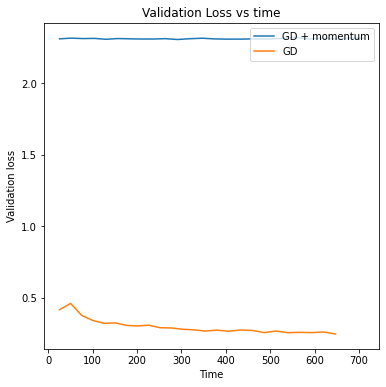

In [ ]:
plt.figure(figsize=(6, 6))
#plt.plot(sgd1_time,sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(gdm1_time,gdm1_valid_loss_history, label='GD + momentum')
plt.plot(gd1_time,gd1_valid_loss_history, label='GD')
#plt.plot(nest1_time, nest1_valid_loss_history, label='NESTROV')

#plt.plot(sgd1_valid_loss_history,'r--', label='SGD')
#plt.plot(gd1_valid_loss_history,'b--', label='GD')
#plt.plot(nest1_valid_loss_history, 'g--', label='NESTROV')


plt.legend(loc="upper right")
plt.xlabel('Time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

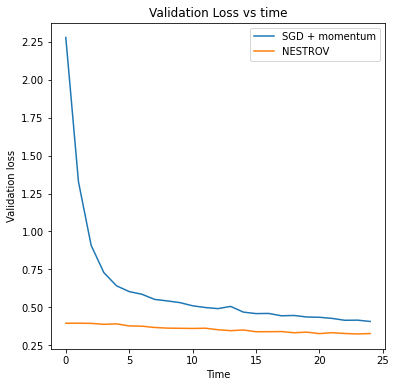

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(sgd1_valid_loss_history, label='SGD + momentum')
#plt.plot(gdm1_valid_loss_history, label='GD + momentum')
#plt.plot(gd1_valid_loss_history, label='GD')
plt.plot(nest1_valid_loss_history, label='NESTROV')

plt.legend(loc="upper right")
plt.xlabel('Time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

In [45]:
# Copy and Paste ---- everything I did here
from numpy import linalg as LA


class myRNA:
    def rna(self, X,reg=0):
        # Regularized Nonlinear Acceleration
        # Take a matrix X of iterates, where X[:,i] is the ith iteration of the
        # fixed-point operation
        #   x_i = g(x_{i-1})
        #
        # reg is the regularization parameter used for solving the system
        #   (R'R + reg I)z = 1
        # where R is the matrix of residuals, i.e. R[:,i] = x_{i+1}-x_{i}
      
      
        # Recovers parameters, ensure X is a matrix
        (d,k) = np.shape(X);
        k = k-1;
        X = np.asmatrix(X); # check if necessary
        
        # Compute the matrix of residuals
        R = np.diff(X);
        
        # "Square" the matrix, and normalize it
        RR = np.dot(np.transpose(R),R);
        normRR = LA.norm(RR,2);
        RR = RR/normRR;
        
        # Solve (R'R + lambda I)z = 1
        (extr,c) = self.rna_precomputed(X,RR,reg)
        # Compute the extrapolation / weigthed mean  "sum_i c_i x_i", and return
        return extr,c
    
    def min_eignevalRR(self, X):
        # Recovers parameters, ensure X is a matrix
        (d,k) = np.shape(X);
        k = k-1;
        X = np.asmatrix(X);
        
        # Compute the matrix of residuals
        R = np.diff(X);
        
        # "Square" the matrix, and normalize it
        RR = np.dot(np.transpose(R),R);
        normRR = LA.norm(RR,2);
        RR = RR/normRR;
        eigenvalues = LA.eigvalsh(RR)
        return np.amin(eigenvalues)
    
    def rna_precomputed(self, X,RR,reg=0):
        # Regularized Nonlinear Acceleration, with RR precomputed
        # Same than rna, but RR is computed only once
        # Recovers parameters
        (d,k) = X.shape;
        k = k-1;
        # RR is already computed, we do not need this step anymor
        # # Compute the matrix of residuals
        # R = np.diff(X);
        # # "Square" the matrix, and normalize it
        # RR = np.dot(np.transpose(R),R);
        # normRR = LA.norm(RR,2);
        # RR = RR/normRR;
        # Solve (R'R + lambda I)z = 1
        reg_I = reg*np.eye(k);
        ones_k = np.ones(k);
        # In case of singular matrix, we solve using least squares instead
        try:
            z = np.linalg.solve(RR+reg_I, ones_k);
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1);
            z = z[0]
        # Recover weights c, where sum(c) = 1
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        c = np.asmatrix(z/np.sum(z)).T;
        
        # Compute the extrapolation / weigthed mean  "sum_i c_i x_i", and return
        extr = np.dot(X[:,1:k+1],c[:,0]);
        return np.array(extr),c

In [46]:
# import regularized_nonlinear_acceleration as RNA
import torch
import numpy as np

myRNA_ob = myRNA()

class AccelerationModule:
    
    # Variables
    # x_hist (list)
    # K (integer)
    # reg_acc (double)
    # cont_type (string)
    # input_shape (dictionnary)

    def __init__(self,model,cont_type="state_dict",K=15,reg_acc=1e-5,store_each=1):
        
        self.store_counter = 0;
        
        self.x_hist = []
        self.K = K
        self.reg_acc = reg_acc
        self.cont_type = cont_type
        self.input_shape = dict()
        self.store_each = store_each
        
        if(self.cont_type == "state_dict"):
            for key in model.state_dict().keys(): # check if it works without keys()
                param = model.state_dict()[key]
                param_np = param.cpu().numpy()
                self.input_shape[key] = (param_np.shape,param_np.size)
                
                
    def extract_x(self,model):
        new_x = []
        if(self.cont_type == "state_dict"):
            for key in self.input_shape.keys():
                param = model.state_dict()[key].cpu().numpy().ravel()
                new_x.append(param)
                
            new_x_cat = np.array(np.concatenate(new_x))
            
                   
        return new_x_cat
        
        
    def store(self,model):
        self.store_counter += 1;
        if(self.store_counter >= self.store_each):
            self.store_counter = 0; #reset and continue
        else:
            return 
        
        if(len(self.x_hist)>(self.K)): # with this, len(x_hist) < K+1, so number of coeffs < K
            self.x_hist.pop(0)
            
        
        self.x_hist.append(self.extract_x(model))
        
    
    def load_param_in_model(self,x,model,x0=None,step_size=1):
        first_idx = 0
        last_idx = 0
        if(self.cont_type == "state_dict" ):
            new_state_dict = model.state_dict()#dict()
            for key in self.input_shape.keys():
                (shape,nElem) = self.input_shape[key]
                last_idx = first_idx + nElem
                if(x0 is None):
                    newEntry = x[first_idx:last_idx].reshape(shape)
                else:
                    newEntry = (1-step_size)*x0[first_idx:last_idx].reshape(shape) + step_size*x[first_idx:last_idx].reshape(shape)
                new_state_dict[key].copy_(torch.Tensor(newEntry))
                first_idx = last_idx
                               
        
    def min_eigenval(self):
        x_hist_np=np.array(self.x_hist).transpose()
        min_eig = myRNA_ob.min_eignevalRR(x_hist_np)
        return min_eig
        
    
    def accelerate(self,model,validation_fun = None, eigenval_offset = 0, step_size = 1.0):
        
        if(len(self.x_hist)<3): # Cannot accelerate when number of points is below 3
            self.load_param_in_model(np.array(self.x_hist[-1]),model)
            return 1;
        
        x_hist_np=np.array(self.x_hist).transpose()
        # print(f"this is the shaaaape of x_hist_np-  -{np.shape(x_hist_np)}")
        if(validation_fun is not None):
            def objective(x):
                self.load_param_in_model(x,model)
                return -validation_fun(model)
            x_acc,c = myRNA_ob.adaptive_rna(x_hist_np,objective, eigenval_offset = eigenval_offset)
        else:
            x_acc,c = myRNA_ob.rna(x_hist_np,self.reg_acc)
            
        if (step_size == 1.0):
            self.load_param_in_model(x_acc,model)
        else:
            self.load_param_in_model(x_acc,model,self.x_hist[-1],step_size)
        
        return c

In [47]:
##train
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x



DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(DEVICE)
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [48]:
import timeit


##SGD plus momentum
#stop_condition = False
K = 10
epochs = 25

valid_loss_history=[]
train_loss_history=[]
time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) 

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9
                      # , dampening = 0
                      # , weight_decay = 0
                      )




accMod = AccelerationModule(network, K=2)

#time_vec.append(0)

start = time.time()

for epoch in range(0, epochs):
    
    train_loss = 0
    valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            valid_loss += loss.item()*data.size(0)
    #gdm1_time.append(elapsed_time_fl)
    
    elapsed_time_fl = (time.time() - start)
    time_vec.append(elapsed_time_fl)
    
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_loss_history.append(valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
    print("Top-1 score: %f", 100.0 * correct/num_samples)

Top-1 score: %f 70.95
Top-1 score: %f 77.79166666666667
Top-1 score: %f 80.65
Top-1 score: %f 82.5
Top-1 score: %f 83.925
Top-1 score: %f 84.74166666666666
Top-1 score: %f 85.375
Top-1 score: %f 85.66666666666667
Top-1 score: %f 86.3
Top-1 score: %f 86.75
Top-1 score: %f 87.5
Top-1 score: %f 88.05
Top-1 score: %f 88.0
Top-1 score: %f 88.15
Top-1 score: %f 88.5
Top-1 score: %f 88.9
Top-1 score: %f 88.74166666666666
Top-1 score: %f 88.86666666666666
Top-1 score: %f 89.34166666666667
Top-1 score: %f 89.68333333333334
Top-1 score: %f 89.20833333333333
Top-1 score: %f 89.475
Top-1 score: %f 89.63333333333334
Top-1 score: %f 89.86666666666666
Top-1 score: %f 89.84166666666667


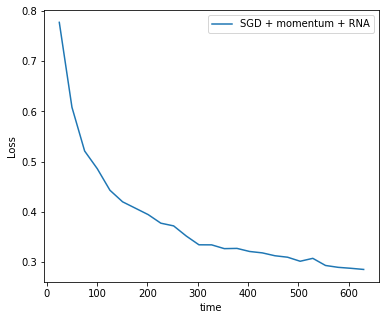

In [49]:
plt.figure(figsize=(6, 5))
plt.plot(time_vec, valid_loss_history, label='SGD + momentum + RNA')
#plt.plot(gd_valid_loss_history, label='GD')
#plt.plot(nest_valid_loss_history, label='NESTROV')

#plt.plot(sgd_valid_acc_history, label='SGD Acc')
#plt.plot(gd_valid_acc_history, label='GD ACC')
#plt.plot(nest_valid_acc_history, label='NESTROV ACC')

plt.xlabel('time')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

In [50]:
##Nestrov plus momentum


#stop_condition = False
K = 10
epochs = 25

nest_valid_loss_history=[]
nest_train_loss_history=[]
nest_time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) # e.g., CIFAR10

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9, nesterov= True
                      # , dampening = 0
                      # , weight_decay = 0
                      )


#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)

##nesterov (bool, optional) – enables Nesterov momentum (default: False)


accMod = AccelerationModule(network, K=2)

#nest_time_vec.append(0)

start = time.time()

for epoch in range(0, epochs):
    
    nest_train_loss = 0
    nest_valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        #train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            nest_valid_loss += loss.item()*data.size(0)
   
    elapsed_time_fl = (time.time() - start)
    nest_time_vec.append(elapsed_time_fl)
            
    nest_valid_loss = nest_valid_loss/len(valid_loader.sampler)
    nest_valid_loss_history.append(nest_valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
           
    print("Top-1 score: %f", 100.0 * correct/num_samples)

Top-1 score: %f 90.175
Top-1 score: %f 90.11666666666666
Top-1 score: %f 90.2
Top-1 score: %f 90.5
Top-1 score: %f 90.18333333333334
Top-1 score: %f 90.29166666666667
Top-1 score: %f 90.40833333333333
Top-1 score: %f 90.46666666666667
Top-1 score: %f 90.68333333333334
Top-1 score: %f 90.66666666666667
Top-1 score: %f 90.25
Top-1 score: %f 90.35833333333333
Top-1 score: %f 90.35833333333333
Top-1 score: %f 90.6
Top-1 score: %f 90.425
Top-1 score: %f 90.8
Top-1 score: %f 90.59166666666667
Top-1 score: %f 90.26666666666667
Top-1 score: %f 90.60833333333333
Top-1 score: %f 90.64166666666667
Top-1 score: %f 90.63333333333334
Top-1 score: %f 90.74166666666666
Top-1 score: %f 90.49166666666666
Top-1 score: %f 90.43333333333334
Top-1 score: %f 90.725


In [ ]:
#stop_condition = False
K = 10
epochs = 25

gd_valid_loss_history=[]
gd_train_loss_history=[]
gd_time_vec =[]

(train_loader ,validation_loader) = (train_loader, valid_loader) # e.g., CIFAR10

network = net
networkACC = Net().to(DEVICE)

criterion = nn.CrossEntropyLoss()# 

##SGD optimizer

optimizer = optim.RMSprop(net.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False
                      # , dampening = 0
                      # , weight_decay = 0
                      )
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)




accMod = AccelerationModule(network, K=2)



start = time.time()

for epoch in range(0, epochs):
    
    gd_train_loss = 0
    gd_valid_loss = 0
    
    # Train for one epoch
    for batch_index, (data, target) in enumerate (train_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)

        data, target = data.to(DEVICE), target.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        #output = net(data)
        predictions = network(data)
        #output = model(data)
        
        loss = criterion(predictions, target)
        #loss.forward(predictions , target)
        
        # Backward pass + optimizer step
        loss.backward()
        # rna_optimizer.step()
        optimizer.step()
        # update training loss
        #train_loss += loss.item()*data.size(0)

    
    # Store the gradient estimate , then recover extrapolation
    # rna_optimizer.store()
    # rna_optimizer.accelerate(network_extr)
    # For the online acceleration version , uncomment this line
    # network.load_params(network_extr.params)
    
    # Test on the validation set
    correct = 0
    total = 0

    num_samples = 0
    with torch.no_grad():
        accMod.store(network)
        accMod.accelerate(networkACC)
        
        for batch_index, (data, target) in enumerate (valid_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            predictions = networkACC(data)
            
            num_samples += data.shape[0]
            # loss += img.shape[0] * loss_f(outp, lbl).item()
            loss = criterion(predictions, target)
            pred = predictions.argmax(dim=1)
            
            correct += (pred == target).sum().item()
            # update validation loss
            gd_valid_loss += loss.item()*data.size(0)
    
    
    elapsed_time_fl = (time.time() - start)
    gd_time_vec.append(elapsed_time_fl)
            
    gd_valid_loss = gd_valid_loss/len(valid_loader.sampler)
    gd_valid_loss_history.append(gd_valid_loss)
            # correct += sum(predictions == target)
            # total += length(targets)
            
    print("Top-1 score: %f", 100.0 * correct/num_samples)

Top-1 score: %f 88.95
Top-1 score: %f 88.81666666666666
Top-1 score: %f 90.05833333333334
Top-1 score: %f 90.15
Top-1 score: %f 90.35833333333333
Top-1 score: %f 90.475
Top-1 score: %f 90.86666666666666
Top-1 score: %f 90.55
Top-1 score: %f 90.86666666666666
Top-1 score: %f 91.28333333333333
Top-1 score: %f 90.53333333333333
Top-1 score: %f 90.38333333333334
Top-1 score: %f 90.875
Top-1 score: %f 90.76666666666667
Top-1 score: %f 90.975
Top-1 score: %f 91.15
Top-1 score: %f 90.98333333333333
Top-1 score: %f 91.25
Top-1 score: %f 91.11666666666666
Top-1 score: %f 91.25833333333334
Top-1 score: %f 90.94166666666666
Top-1 score: %f 91.325
Top-1 score: %f 91.075
Top-1 score: %f 91.1
Top-1 score: %f 91.28333333333333


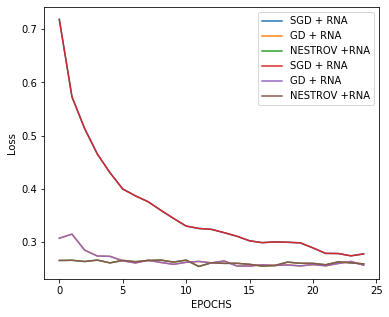

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

#plt.plot(sgd_valid_acc_history, label='SGD Acc')
#plt.plot(gd_valid_acc_history, label='GD ACC')
#plt.plot(nest_valid_acc_history, label='NESTROV ACC')

plt.xlabel('EPOCHS')
plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
plt.legend()
plt.show()

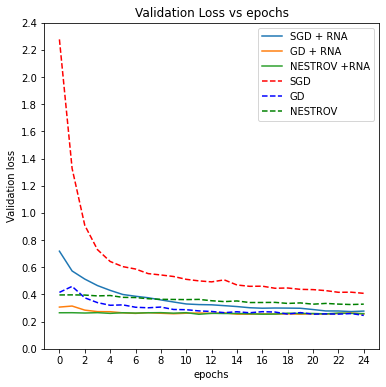

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV +RNA')

plt.plot(sgd1_valid_loss_history,'r--', label='SGD')
plt.plot(gd1_valid_loss_history,'b--', label='GD')
plt.plot(nest1_valid_loss_history, 'g--', label='NESTROV')


plt.legend(loc="upper right")
plt.xlabel('epochs')
plt.yticks(np.arange(0, 2.5, step=0.2))
plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs epochs")
plt.show()

In [ ]:
import torch as T
import numpy as np
from numpy import linalg as LA
from torch.optim import Optimizer, SGD
import copy

class online_rna(SGD):
    
    def __init__(self,params, lr,momentum=0.9,dampening=0,weight_decay=0,nesterov=False,K=10,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec

In [ ]:
import argparse
from torch.autograd import Variable

#import online_rna
from copy import deepcopy
#import csv




class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding =1)
        # linear layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10) 
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        # max pooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flattening the image
        x = x.view(-1, 7*7*16)
        # linear layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
net = Net()
print(net)
net2 = net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-8,nesterov=False,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    valid_loss = 0
    global val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    valid_loss = valid_loss/len(valid_loader.sampler)

    val_arr.append(valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(valid_loss, 6)}')

In [ ]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 

osgd_time_vec =[]
start = time.time()

for epoch in range(1, epochs+1):
    train_loss = 0
    # Schedule
    new_lr = lr_scheduler(35,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start) 
    osgd_time_vec.append(elapsed_time_fl)
        
    train_loss = train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer.store(model=net)
    if(epoch == 1):
        optimizer.reset_buffers()
    if(epoch > 1):
        c = optimizer.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input



########### EPOCH: 1 WITH LEARNING RATE: 0.0004166666666666659


Current Epoch: 1
Training Loss: 2.301545
Current Epoch: 1
Validation Loss: 2.298981


########### EPOCH: 2 WITH LEARNING RATE: 0.0008333333333333335


Current Epoch: 2
Training Loss: 2.292132
Current Epoch: 2
Validation Loss: 2.27811

 ACCELERATION 

[1.0]




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Current Epoch: 2
Validation Loss: 2.278141


########### EPOCH: 3 WITH LEARNING RATE: 0.0012499999999999994


Current Epoch: 3
Training Loss: 2.00517
Current Epoch: 3
Validation Loss: 1.228412

 ACCELERATION 

[1.1518650822053251, -0.15186508220532519]


Current Epoch: 3
Validation Loss: 2.295629


########### EPOCH: 4 WITH LEARNING RATE: 0.001666666666666667


Current Epoch: 4
Training Loss: 2.264336
Current Epoch: 4
Validation Loss: 2.112609

 ACCELERATION 

[1.2056072504028414, -0.1383332865896171, -0.06727396381322431]


Current Epoch: 4
Validation Loss: 2.296632


########### EPOCH: 5 WITH LEARNING RATE: 0.0020833333333333346


Current Epoch: 5
Training Loss: 2.162405
Current Epoch: 5
Validation Loss: 1.339755

 ACCELERATION 

[1.1388117569752632, -0.07218717823874363, 0.12502847002838285, -0.1916530487649025]


Current Epoch: 5
Validation Loss: 2.299019


########### EPOCH: 6 WITH LEARNING RATE: 0.0025000000000000005


Current Epoch: 6
Training Loss: 2.214669
Current Epoch: 6
Val

hahouwa:  [2.2781410574913026, 2.2956289569536845, 2.2966320395469664, 2.2990188896656036, 2.2975498100121814, 2.294768687089284, 2.2941215058167774, 2.293987876176834, 2.292385007937749, 2.2916822612285612, 2.238679673274358, 2.2425915598869324, 1.0265263423323632, 0.6632022649049759, 0.47745634814103444, 0.4438781758149465, 0.42035433898369473, 0.40163054230312506, 0.39299908181031545, 0.38346776689092316, 0.3833287293712298, 0.3796285502612591, 0.3710323993116617, 0.36615264092882477]


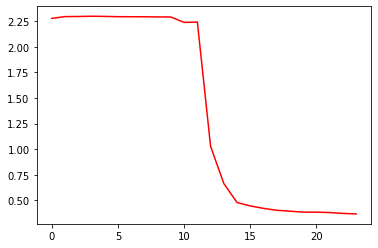

In [ ]:

cut=val_arr[1:]
rna_online=[cut[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online)

#Plot loss
#np.save('online_rna_sgd.npy', rna_online)

plt.plot(rna_online, 'r')
#cnn_online.py

GD PLUS ONLINE RNA

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, dampening=0, weight_decay=0, nesterov= True)
#optimizer2 = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [51]:
from torch.optim import Optimizer, RMSprop

class online_rna(RMSprop):
    
    def __init__(self,params, lr=0.01,momentum=0,dampening=0,weight_decay=0,nesterov=False,K=10,alpha=0.99,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, alpha, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec

In [52]:
# In[]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer2 = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-8,alpha = 0.99,nesterov=False,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
gd_val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    gd_valid_loss = 0
    global gd_val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        gd_valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    gd_valid_loss = gd_valid_loss/len(valid_loader.sampler)

    gd_val_arr.append(gd_valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(gd_valid_loss, 6)}')

In [53]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 
ogd_time_vec = []
start = time.time()
for epoch in range(1, epochs+1):
    gd_train_loss = 0
    # Schedule
    new_lr = lr_scheduler(25,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer2.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer2.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer2.step()
        # update training loss
        gd_train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start)
    ogd_time_vec.append(elapsed_time_fl)
        
    gd_train_loss = gd_train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(gd_train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer2.store(model=net)
    if(epoch == 1):
        optimizer2.reset_buffers()
    if(epoch > 1):
        c = optimizer2.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input



########### EPOCH: 1 WITH LEARNING RATE: 0.0007142857142857142


Current Epoch: 1
Training Loss: 0.217622
Current Epoch: 1
Validation Loss: 0.245833


########### EPOCH: 2 WITH LEARNING RATE: 0.0014285714285714284


Current Epoch: 2
Training Loss: 0.217313
Current Epoch: 2
Validation Loss: 0.241895

 ACCELERATION 

[1.0]


Current Epoch: 2
Validation Loss: 0.362985


########### EPOCH: 3 WITH LEARNING RATE: 0.0021428571428571425


Current Epoch: 3
Training Loss: 0.217024
Current Epoch: 3
Validation Loss: 0.244876

 ACCELERATION 

[0.46949795329812183, 0.5305020467018782]


Current Epoch: 3
Validation Loss: 0.356236


########### EPOCH: 4 WITH LEARNING RATE: 0.0028571428571428567


Current Epoch: 4
Training Loss: 0.218113
Current Epoch: 4
Validation Loss: 0.241782

 ACCELERATION 

[0.2812238341618837, 0.35098610369726846, 0.3677900621408478]


Current Epoch: 4
Validation Loss: 0.359044


########### EPOCH: 5 WITH LEARNING RATE: 0.0035714285714285718


Current Epoch: 5
Training Loss: 0

In [ ]:
cut2=gd_val_arr[1:]
rna_online2=[cut2[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online2)
# In[]:
#Plot loss
np.save('online_rna_sgd.npy', rna_online2)

# In[]:
plt.plot(rna_online2, 'g')
#cnn_online.py

NESTROV PLUS ONLINE RNA

In [54]:
class online_rna(SGD):
    
    def __init__(self,params, lr,momentum=0,dampening=0,weight_decay=0,nesterov=True,K=10,reg_acc=1e-5,acceleration_type='online',do_average=False):
        
        self.params = list(params)
        
        super(online_rna, self).__init__(self.params, lr, momentum, dampening, weight_decay, nesterov)
        self.K = K
        self.reg_acc = reg_acc
        self.do_average = do_average
        
        self.acceleration_type = acceleration_type
        
        for group in self.param_groups:
            group['running_avg_model'] = dict()
            group['running_avg_grad'] = dict()
            group['avg_model_hist'] = dict()
            group['avg_grad_hist'] = dict()
            group['avg_counter'] = dict()
        self.reset_buffers()
        
        if(acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_buffers(self):
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                avg_model_hist[param] = []
                avg_grad_hist[param] = []
        self.reset_running_avg()
        
        if(self.acceleration_type == 'offline'):
            self.dict_hist = list()

    
    def reset_running_avg(self):
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                avg_counter[param] = 0
                running_avg_model[param] = None
                running_avg_grad[param] = None


    def update_lr(self,lr):
        for group in self.param_groups:
            group['lr'] = lr
            
            
    def update_running_avg(self):
        
        for group in self.param_groups:
            avg_counter = group['avg_counter']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            
            for param in group['params']:
                avg_counter[param] += 1
                if(avg_counter[param] == 1):
                    running_avg_model[param] = param.data.clone()
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = param.grad.data.clone()
                else:
                    # weight_avg_x = (avg_counter[param]-1)/avg_counter[param]
                    weight_avg_x = 0 #take the last one
                    
                    weight_avg_grad = (avg_counter[param]-1)/avg_counter[param]
                    # weight_avg_grad = 0 #take the last one
                    
                    running_avg_model[param] = running_avg_model[param].mul(weight_avg_x) + param.data.clone().mul(1-weight_avg_x)
                    if(param.grad is None):
                        running_avg_grad[param] = None
                    else:
                        running_avg_grad[param] = running_avg_grad[param].mul(weight_avg_grad) + param.grad.data.clone().mul(1-weight_avg_grad)
        
    
    def step(self):
        super(online_rna, self).step()
        self.update_running_avg()
             
    
    def store(self,model=None):
        
        for group in self.param_groups:
            avg_model_hist = group['avg_model_hist']
            avg_grad_hist = group['avg_grad_hist']
            running_avg_model = group['running_avg_model']
            running_avg_grad = group['running_avg_grad']
            for param in group['params']:
                if(len(avg_model_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_model_hist[param].pop(0)
                if(len(avg_grad_hist[param])>=(self.K)): # with this, len(hist) < K
                    avg_grad_hist[param].pop(0)
        
                avg_model_hist[param].append(copy.deepcopy(running_avg_model[param]))
                if(running_avg_grad[param] is not None):
                    avg_grad_hist[param].append(copy.deepcopy(running_avg_grad[param].cpu().numpy().ravel()))
        self.reset_running_avg()
        # self.reset_momentum()
        
        
        if(self.acceleration_type == 'offline'):
            if(model is None):
                raise ValueError('Problem in rna.store(): model cannot be none in offline acceleration')
                
            if(len(self.dict_hist)>=(self.K)): # with this, len(hist) < K
                self.dict_hist.pop(0)
            self.dict_hist.append(copy.deepcopy(model.state_dict()))
        
    
    def reset_momentum(self):
        for group in self.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                if 'momentum_buffer' in param_state:
                    param_state['momentum_buffer'].mul_(0)
    
    def compute_c_rna(self):
        
        gradient_buffer = []
        for group in self.param_groups:
            avg_grad_hist = group['avg_grad_hist']
            for param in group['params']:
                if(len(avg_grad_hist[param]) == 0):
                    continue
                entry = np.asmatrix(avg_grad_hist[param])
                gradient_buffer.append(entry)
        gradient_buffer = np.concatenate(gradient_buffer,axis=1)
        
        R = np.asmatrix(gradient_buffer)
        (k,d) = np.shape(R)
        
        RR = np.dot(R,np.transpose(R))
        normRR = LA.norm(RR,2)
        RR = RR/normRR
        
        reg_I = self.reg_acc*np.eye(k)
        ones_k = np.ones(k)
        
        try:
            z = np.linalg.solve(RR+reg_I, ones_k)
        except LA.linalg.LinAlgError:
            z = np.linalg.lstsq(RR+reg_I, ones_k, -1)
            z = z[0]
        
        if( np.abs(np.sum(z)) < 1e-10):
            z = np.ones(k)
        
        c = (z/np.sum(z)).tolist()
        
        return c
    
    def accelerate(self,model=None):
        c_vec = self.compute_c_rna()

        if(self.do_average):
            k = len(c_vec)
            z = np.ones(k)
            c_vec = (z/np.sum(z)).tolist()
        
        if(self.acceleration_type.lower() == 'online'):
            for group in self.param_groups:
                avg_model_hist = group['avg_model_hist']
                for param in group['params']:
                    param.data.mul_(0.0);
                    for (i, c) in enumerate(c_vec):
                        param.data.add_(c,avg_model_hist[param][i])
        
        if(self.acceleration_type.lower() == 'none'):
            print('No acceleration')
            pass
        
        
        if(self.acceleration_type.lower() == 'offline'):
            if(model is not None):
                    
                new_dict = dict(model.state_dict())
                for key in new_dict:
                    new_dict[key].mul_(0);
                    for idx_c in range(0,len(c_vec)):
                        new_dict[key].add_(c_vec[idx_c],self.dict_hist[idx_c][key])
                model.load_state_dict(new_dict)
            else:
                raise ValueError('Problem in rna.accelerate(): model cannot be none in offline acceleration')
        
        return c_vec

In [55]:
# In[]:
def lr_scheduler(max_epoch,lr_0,lr_final,epoch):
    epoch_stabilization = 10;
    if(epoch<max_epoch-epoch_stabilization):
        lr = lr_final + (lr_0-lr_final)*(1-(1.0*epoch/(1.0*(max_epoch-epoch_stabilization-1))))
    else:
        lr = lr_final
    return lr;
#weight_decay=1e-5
# In[]:

# loss function (cross entropy loss)
criterion = nn.CrossEntropyLoss()
new_lr = lr_scheduler(25,lr_0=1,lr_final = 0.001,epoch=0)
optimizer3 = online_rna(net.parameters(),lr=new_lr,momentum=0.9,weight_decay=1e-5,nesterov=True,K=10,reg_acc=0,acceleration_type='online',do_average=False)

# In[]:
#define test/validation function
nest_val_arr=[]
def test(net): # tag:RNA # We have to specify the input
    nest_valid_loss = 0
    global nest_val_arr
 
    net.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = Variable(data), Variable(target)
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # update validation loss
        nest_valid_loss += loss.item()*data.size(0)
        
    # average loss calculations
    nest_valid_loss = nest_valid_loss/len(valid_loader.sampler)

    nest_val_arr.append(nest_valid_loss) 
    
    # Display loss statistics
    print(f'Current Epoch: {epoch}\nValidation Loss: {round(nest_valid_loss, 6)}')

In [56]:
#TRAINING :
    
# epochs to train for
epochs = 25
# tracks validation loss change after each epoch
#minimum_validation_loss = np.inf 
onest_time_vec = []
start = time.time()
for epoch in range(1, epochs+1):
    nest_train_loss = 0
    # Schedule
    new_lr = lr_scheduler(25,lr_0=0,lr_final=0.01,epoch=epoch)
    optimizer3.update_lr(new_lr)
    
    print('\n\n########### EPOCH: ' +str(epoch) + ' WITH LEARNING RATE: ' +str(new_lr)+'\n\n')
    # training steps
    net.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # moves tensors to GPU
        
        data, target = Variable(data), Variable(target)
        # clears gradients
        optimizer3.zero_grad()
        # forward pass
        output = net(data)
        # loss in batch
        loss = criterion(output, target)
        # backward pass for loss gradient
        loss.backward()
        # update paremeters
        optimizer3.step()
        # update training loss
        nest_train_loss += loss.item()*data.size(0)
        
    elapsed_time_fl = (time.time() - start)
    onest_time_vec.append(elapsed_time_fl)
        
    nest_train_loss = nest_train_loss/len(train_loader.sampler)
    print(f'Current Epoch: {epoch}\nTraining Loss: {round(nest_train_loss, 6)}')    
 
    test(net) # tag:RNA # test requires now an input
   
    optimizer3.store(model=net)
    if(epoch == 1):
        optimizer3.reset_buffers()
    if(epoch > 1):
        c = optimizer3.accelerate(net2)
        print("\n ACCELERATION \n")
        print(c)
        print("\n")
        test(net2) # tag:RNA # test requires now an input



########### EPOCH: 1 WITH LEARNING RATE: 0.0007142857142857142


Current Epoch: 1
Training Loss: 0.217443
Current Epoch: 1
Validation Loss: 0.241988


########### EPOCH: 2 WITH LEARNING RATE: 0.0014285714285714284


Current Epoch: 2
Training Loss: 0.220046
Current Epoch: 2
Validation Loss: 0.244585

 ACCELERATION 

[1.0]


Current Epoch: 2
Validation Loss: 0.359324


########### EPOCH: 3 WITH LEARNING RATE: 0.0021428571428571425


Current Epoch: 3
Training Loss: 0.220988
Current Epoch: 3
Validation Loss: 0.246116

 ACCELERATION 

[0.4930518879871871, 0.506948112012813]


Current Epoch: 3
Validation Loss: 0.35816


########### EPOCH: 4 WITH LEARNING RATE: 0.0028571428571428567


Current Epoch: 4
Training Loss: 0.223895
Current Epoch: 4
Validation Loss: 0.246397

 ACCELERATION 

[0.3254081589105731, 0.3449435942807405, 0.3296482468086864]


Current Epoch: 4
Validation Loss: 0.361871


########### EPOCH: 5 WITH LEARNING RATE: 0.0035714285714285718


Current Epoch: 5
Training Loss: 0.224

hahouwa:  [0.35932400822639465, 0.3581603522102038, 0.3618708625435829, 0.358469453578194, 0.35666709976891675, 0.36103462874889375, 0.3606269103785356, 0.3619968956957261, 0.3579882522424062, 0.35744893811643125, 0.3588896879305442, 0.3628657550861438, 0.3641415840635697, 0.35890620537102225, 0.3571970249215762, 0.3616127600272497, 0.35808060467243197, 0.3630922214438518, 0.3618498079478741, 0.3555652181307475, 0.36261726431548597, 0.3606353681534529, 0.35623607176045574, 0.35908044142027695]


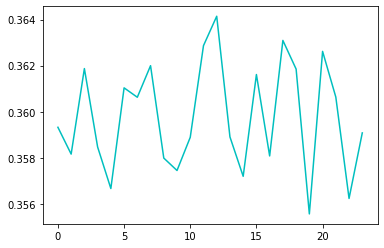

In [57]:
cut3=nest_val_arr[1:]
rna_online3=[cut3[i] for i in range(len(cut)) if i % 2 == 1]
print("hahouwa: ", rna_online3)
# In[]:
#Plot loss
#np.save('online_rna_sgd.npy', rna_online3)

# In[]:
plt.plot(rna_online3, 'c')
#cnn_online.py

NameError: ignored

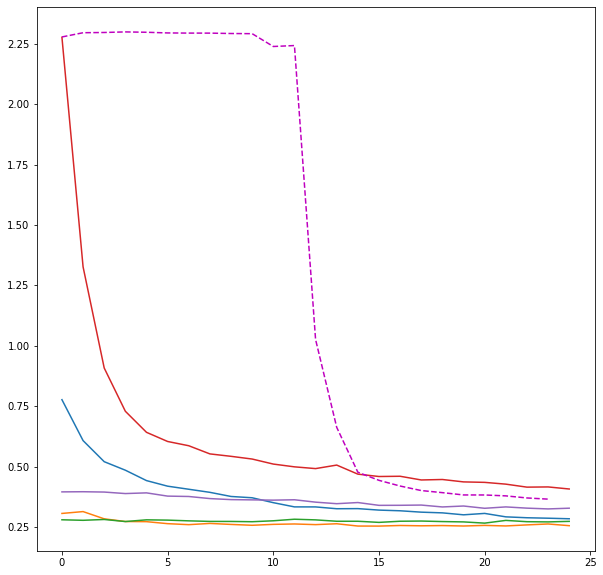

In [58]:
###all epochs combined

plt.figure(figsize=(10, 10))

plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(gd_valid_loss_history, label='GD + momentum + RNA')
plt.plot(nest_valid_loss_history, label='NESTROV + RNA')

plt.plot(sgd1_valid_loss_history, label='SGD')
#plt.plot(gd1_valid_loss_history, label='GD')
#plt.plot(gdm1_valid_loss_history, label='GD + momentum')
plt.plot(nest1_valid_loss_history, label='NESTROV')


plt.plot(rna_online,'m--', label='SGD + online RNA')
plt.plot(rna_online2,'b--' , label='GD + online RNA')
plt.plot(rna_online3,'c--', label='NESTROV + online RNA')

plt.legend(loc="upper right")
plt.xlabel('epochs')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, 26, step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs epochs")
plt.show()

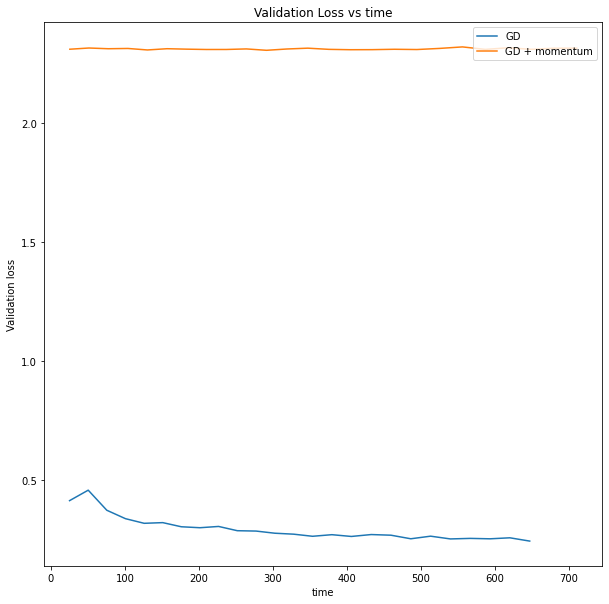

In [59]:
#plt of time GD and Nestrov
plt.figure(figsize=(10, 10))


plt.plot(gd1_time, gd1_valid_loss_history, label='GD')
plt.plot(gdm1_time, gdm1_valid_loss_history, label='GD + momentum')
plt.legend(loc="upper right")
plt.xlabel('time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

NameError: ignored

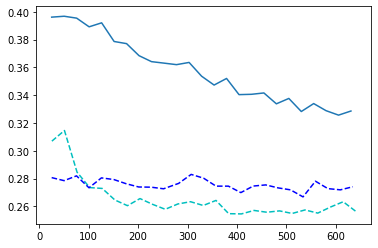

In [60]:
plt.plot(nest1_time, nest1_valid_loss_history, label='NESTROV')


plt.plot(gd_time_vec, gd_valid_loss_history,'c--', label='GD + momentum + RNA')
plt.plot(nest_time_vec, nest_valid_loss_history, 'b--', label='NESTROV + RNA')

plt.plot(ogd_time_vec[:-1], rna_online2,'m--', label='GD + online RNA')
plt.plot(onest_time_vec[:-1], rna_online3,'r--', label='NESTROV + online RNA')

plt.legend(loc="upper right")
plt.xlabel('time')
#plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("Validation Loss vs time")
plt.show()

#plt.xlabel('EPOCHS')
#plt.ylabel('Loss')
#plt.title('GD + MOMENTUM')
#plt.legend()
#plt.show()

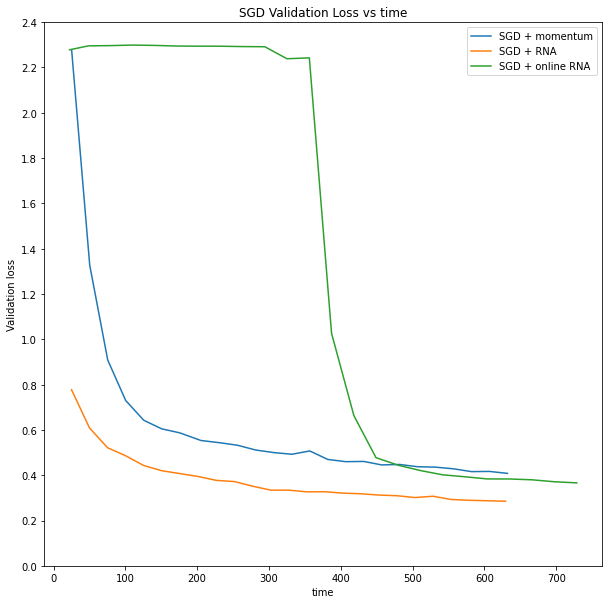

In [61]:
##time SGD
plt.figure(figsize=(10, 10))


plt.plot(sgd1_time, sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(time_vec, valid_loss_history, label='SGD + RNA')
plt.plot(osgd_time_vec[:-1], rna_online, label='SGD + online RNA')

#
plt.legend(loc="upper right")
plt.xlabel('time')
plt.yticks(np.arange(0, 2.5, step=0.2))
#plt.xticks(np.arange(0, , step=2))
plt.ylabel('Validation loss')
plt.title("SGD Validation Loss vs time")
plt.show()

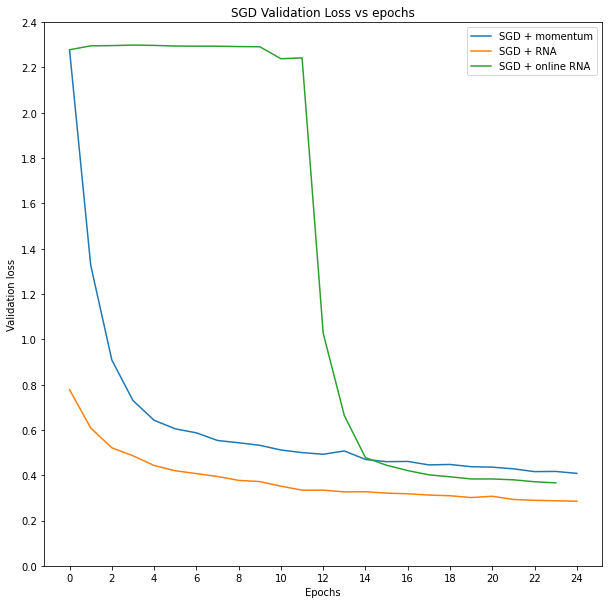

In [62]:
##epochs SGD
plt.figure(figsize=(10, 10))


plt.plot(sgd1_valid_loss_history, label='SGD + momentum')
plt.plot(valid_loss_history, label='SGD + RNA')
plt.plot(rna_online, label='SGD + online RNA')

#
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.yticks(np.arange(0, 2.5, step=0.2))
plt.xticks(np.arange(0, 26 , step=2))
plt.ylabel('Validation loss')
plt.title("SGD Validation Loss vs epochs")
plt.show()